In [53]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Concatenate, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json




In [1]:
!kaggle datasets download -d obulisainaren/multi-cancer

!unzip multi-cancer.zip -d /content/multi-cancer

Streaming output truncated to the last 5000 lines.
  inflating: /content/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0003.jpg  
  inflating: /content/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0004.jpg  
  inflating: /content/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0005.jpg  
  inflating: /content/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0006.jpg  
  inflating: /content/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0007.jpg  
  inflating: /content/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0008.jpg  
  inflating: /content/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0009.jpg  
  inflating: /content/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0010.jpg  
  inflating: /content/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0011.jpg  
  inflating: /content/multi-can

In [54]:
# Define the dataset directory
data_dir = "/content/multi-cancer/Multi Cancer/Multi Cancer"
target_folder = 'ALL'
filepath = []
labels = []

# Loop through the dataset to create the dataframe
all_folder_path = os.path.join(data_dir, target_folder)

if os.path.isdir(all_folder_path):
    filelist = os.listdir(all_folder_path)
    for f in filelist:
        fpath = os.path.join(all_folder_path, f)
        fipath = os.listdir(fpath)
        for image in fipath:
            path = os.path.join(fpath, image)
            filepath.append(path)
            labels.append(f)

f_series = pd.Series(filepath, name='filepath')
l_series = pd.Series(labels, name='labels')
df = pd.concat([f_series, l_series], axis=1)

# Split the data into train, validation, and test sets
strat = df['labels']
train_df, dummy_df = train_test_split(df, test_size=0.3, random_state=42, stratify=strat)
strate = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, test_size=0.5, random_state=42, stratify=strate)

print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)


(14000, 2)
(3000, 2)
(3000, 2)


In [55]:
# Function to load and preprocess images with one-hot encoding for labels
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (128, 128))  # Resize to 128x128 for faster training
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the image

    # One-hot encode the label (assuming label is an integer)
    label = to_categorical(label, num_classes=4)  # Adjust num_classes to your dataset
    return image, label

# Create a tf.data dataset from the dataframe
def create_dataset(dataframe):
    file_paths = dataframe['filepath'].values
    labels = dataframe['labels'].values
    label_map = {label: i for i, label in enumerate(set(labels))}
    labels = [label_map[label] for label in labels]

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Create the datasets
train_dataset = create_dataset(train_df)
valid_dataset = create_dataset(valid_df)
test_dataset = create_dataset(test_df)

In [56]:
df.head()

,filepath,labels
0,/content/multi-cancer/Multi Cancer/Multi Cance...,all_pro
1,/content/multi-cancer/Multi Cancer/Multi Cance...,all_pro
2,/content/multi-cancer/Multi Cancer/Multi Cance...,all_pro
3,/content/multi-cancer/Multi Cancer/Multi Cance...,all_pro
4,/content/multi-cancer/Multi Cancer/Multi Cance...,all_pro


In [57]:
# Lightweight Custom CNN Model
def lightweight_custom_cnn(input_shape):
    inputs = Input(shape=input_shape)

    # First convolution layer with smaller filters
    x = Conv2D(16, (3, 3), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)

    # Second convolution layer with fewer filters
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Third convolution layer with even fewer filters
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten and dense layer
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer for classification
    output = Dense(4, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the model with the input shape
model = lightweight_custom_cnn((128, 128, 3))  # Using 128x128 for faster training
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,121,380 (8.09 MB)

 Trainable params: 2,121,380 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset, callbacks=[early_stopping])



Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.4830 - loss: 1.1152 - val_accuracy: 0.8457 - val_loss: 0.4171
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.8046 - loss: 0.4750 - val_accuracy: 0.8843 - val_loss: 0.2732
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.8638 - loss: 0.3290 - val_accuracy: 0.9433 - val_loss: 0.1608
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - accuracy: 0.9034 - loss: 0.2475 - val_accuracy: 0.9553 - val_loss: 0.1271
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.9265 - loss: 0.1913 - val_accuracy: 0.9453 - val_loss: 0.1302
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.9513 - loss: 0.1303 - val_accuracy: 0.9700 - val_loss: 0.0758
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9357 - loss: 0.1726 - val_accuracy: 0.9753 - val_loss: 0.0816
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.9633 - loss: 0.0987 -

In [59]:
# Evaluate the model on the training, validation, and test datasets
train_score = model.evaluate(train_dataset, verbose=1)
valid_score = model.evaluate(valid_dataset, verbose=1)
test_score = model.evaluate(test_dataset, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.9933 - loss: 0.0228
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9810 - loss: 0.0590
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9790 - loss: 0.0513
Train Loss:  0.022126654163002968
Train Accuracy:  0.9934999942779541
--------------------
Valid Loss:  0.06432732939720154
Valid Accuracy:  0.981333315372467
--------------------
Test Loss:  0.04577714577317238
Test Accuracy:  0.9819999933242798


In [60]:
# Create a label map to map the class names to integers
label_map = {label: i for i, label in enumerate(set(labels))}

# Reverse the label map to map integer indices back to class names
reverse_label_map = {i: label for label, i in label_map.items()}

# Print the class names
class_names = list(label_map.keys())
print("Class Names:", class_names)

Class Names: ['all_benign', 'all_pro', 'all_pre', 'all_early']


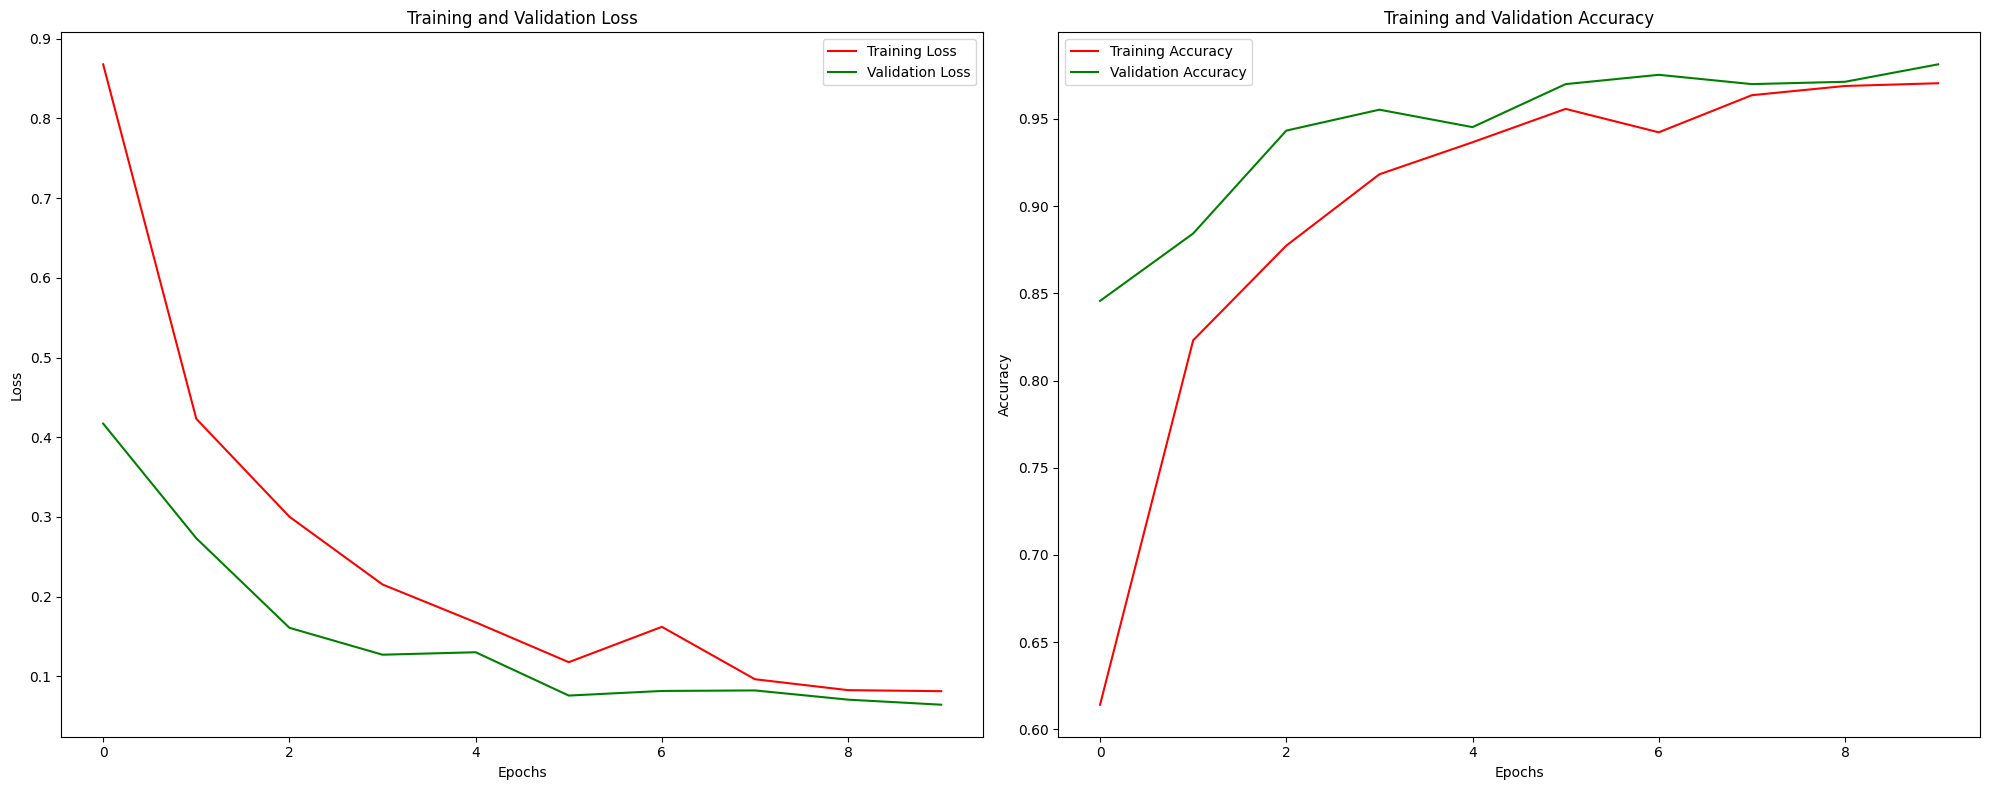

In [61]:
# Plotting the training and validation loss
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'r', label='Training Loss')
plt.plot(history.history['val_loss'], 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━

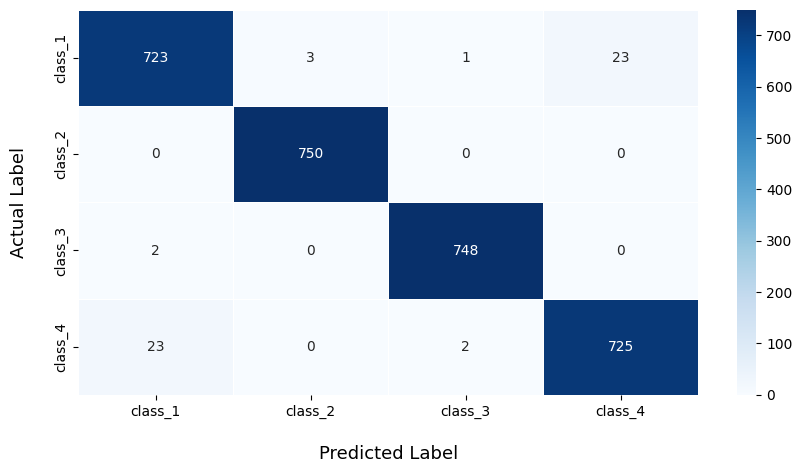

              precision    recall  f1-score   support

     class_1       0.97      0.96      0.97       750
     class_2       1.00      1.00      1.00       750
     class_3       1.00      1.00      1.00       750
     class_4       0.97      0.97      0.97       750

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [66]:
# Confusion Matrix and Classification Report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Ensure the labels are properly extracted and processed
true_labels = []
predicted_labels = []

# Iterate through the test dataset and collect true labels and predicted labels
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Extract true labels (one-hot to indices)
    preds = model.predict(images)  # Get predictions from the model
    predicted_labels.extend(np.argmax(preds, axis=1))  # Get the class index from predictions

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define your labels manually if they are not stored in the dataset
labels = ['class_1', 'class_2', 'class_3', 'class_4']  # Replace with your actual class names

# Plot confusion matrix
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues", linewidths=0.5)
plt.xlabel('\nPredicted Label', fontsize=13)
plt.ylabel('Actual Label\n', fontsize=13)
plt.show()

# Classification report
print(classification_report(true_labels, predicted_labels, target_names=labels))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


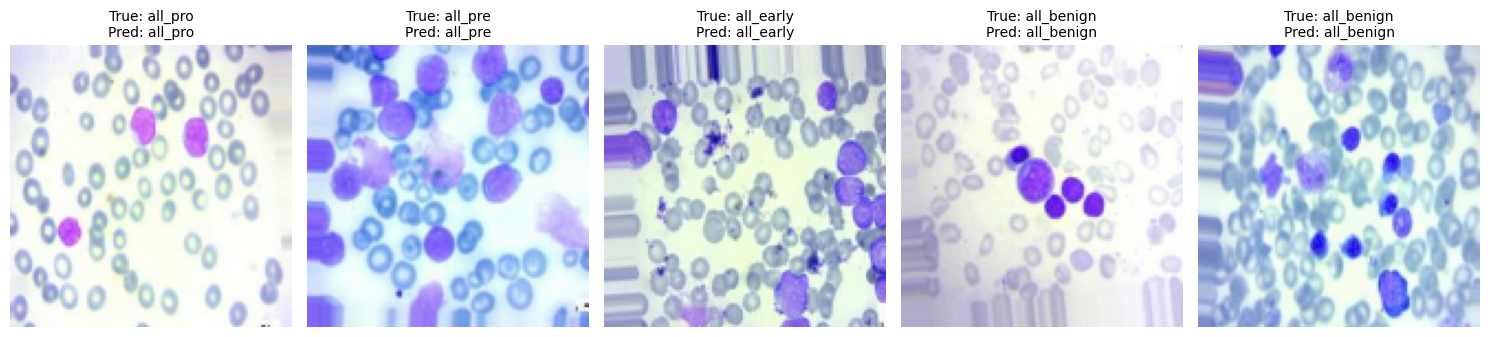

In [69]:
# Visualize predictions for a batch of test images
images, true_labels_batch = next(iter(test_dataset))  # Get a batch of images and true labels

# Get predictions from the model
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(true_labels_batch, axis=1)  # Convert one-hot encoded true labels to class indices

# Visualizing the images with their true and predicted labels
plt.figure(figsize=(15, 15))

for i in range(5):  # Displaying the first 5 images from the batch
    plt.subplot(1, 5, i + 1)

    # Normalize the image for proper display
    image = images[i].numpy()  # Ensure it's a NumPy array if not already
    image = np.clip(image, 0, 1)  # Clip values to ensure they are in the range [0, 1]

    # If images are in grayscale, convert them to RGB format for display
    if image.shape[-1] == 1:  # If grayscale image (1 channel), convert to 3 channels (RGB)
        image = np.repeat(image, 3, axis=-1)

    plt.imshow(image)

    # Get true and predicted labels from their indices
    true_label_name = reverse_label_map[true_labels[i]]  # Map to actual class name
    predicted_label_name = reverse_label_map[predicted_labels[i]]  # Map to actual class name

    # Display the true and predicted labels as the title of the image
    plt.title(f'True: {true_label_name}\nPred: {predicted_label_name}', fontsize=10)
    plt.axis('off')  # Turn off axis for better visualization

plt.tight_layout()
plt.show()